In [ ]:
#| default_exp sampler.experimental

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.subset import SubsetSampler
from qsample.sampler.tree import Variable, Constant, Delta
from copy import deepcopy
import numpy as np

In [ ]:
#| export
class SubsetSamplerERV(SubsetSampler):
    """Subset sampler implementing ERV sampling technique

    Attributes
    ----------
    k : int
        Application of ERV every k-th shots
    """

    def __init__(self, protocol, simulator, p_max, err_model, err_params=None, k=1, L=1):
        super().__init__(protocol, simulator, p_max, err_model, err_params, L)
        self.k = k

    def wplus1(self, tree_node, circuit):
        """Return subsets of this `tree_node` plus next important subset

        Parameters
        ----------
        tree_node : Variable
            Circuit node for which subsets are returned
        circuit : Circuit
            Circuit corresponding to `tree_node`
        """
        Aws = self.tree.constants[circuit.id]
        sampled_subsets = [n.name for n in tree_node.children if type(n) != Delta]
        unsampled_Aws = {k: v for k, v in Aws.items() if k not in sampled_subsets}
        if unsampled_Aws:
            next_important_subset = max(unsampled_Aws, key=lambda k: unsampled_Aws.get(k))
            subset_candidates = sampled_subsets + [next_important_subset]
        else:
            subset_candidates = sampled_subsets

        return subset_candidates

    def _choose_subset(self, circuit_node, circuit):
        """ERV criterium to choose subsets

        For every k-th shot execute ERV, otherwise choose default routine
        `SubsetSampler._choose_subset`.

        Parameters
        ----------
        tree_node : Variable
            Current tree node we want to sample from
        circuit : Circuit
            Current circuit associated with tree node

        Returns
        -------
        tuple
            Next subset to choose for `tree_node`
        """

        if self.tree.root.count % self.k != 0:
            return super()._choose_subset(circuit_node, circuit)

        subset_candidates = self.wplus1(circuit_node, circuit)

        erv_vals = []
        logs = []

        # exclude virtual nodes in calculation of delta
        # vss_contrib = np.prod([self.tree.value(n) for n in circuit_node.children if type(n) == Delta or n.count==0])
        # delta = self.tree.delta / (1 if vss_contrib==0 else vss_contrib)
        d = self.tree.add(name='δ', parent=circuit_node, node_type=Delta)
        #self.tree.deltas.add(d)

        delta = self.tree.delta

        v_L = self.tree.var(mode=1)
        v_L_up = self.tree.var(mode=0)

        # print(self.tree)
        # print(np.sqrt(v_L))

        for subset in subset_candidates:

            subset_node = self.tree.add(name=subset, parent=circuit_node, node_type=Constant)
            """
            if circuit_node.ff_deterministic and not any(subset):
                # erv_vals.append(delta - delta_prime)
                erv_vals.append(0)
                logs.append((subset, 0, 'ff_deterministic!'))
                continue
            """
            children = subset_node.children

            if len(children) == 0:
                child_node_minus = self.tree.add(name=None, parent=subset_node, circuit_id=circuit.id,
                                                 node_type=Variable)
                child_node_plus = self.tree.add(name='FAIL', parent=subset_node, circuit_id=circuit.id,
                                                node_type=Variable)
                self.tree.marked.add(child_node_plus)
            elif len(children) == 1:
                if children[0] in self.tree.marked:
                    child_node_minus = self.tree.add(name=None, parent=subset_node, circuit_id=circuit.id,
                                                     node_type=Variable)
                    child_node_plus = children[0]
                else:
                    child_node_minus = children[0]
                    child_node_plus = self.tree.add(name='FAIL', parent=subset_node, circuit_id=circuit.id,
                                                    node_type=Variable)
                    self.tree.marked.add(child_node_plus)
            elif len(children) == 2:
                child_node_minus, child_node_plus = children
            else:
                raise Exception("Subset nodes not allowed to have more than 2 children.")

            subset_node.count += 1

            # delta_prime = self.tree.delta

            #print(child_node_minus.count)
            child_node_minus.count += 1
            delta_minus = self.tree.delta
            v_L_minus = self.tree.var(mode=1)
            minus_tree = deepcopy(self.tree)
            #print(child_node_minus.count)
            v_L_up_minus = self.tree.var(mode=0)
            child_node_minus.count -= 1
            #print(child_node_minus.count, v_L_minus, v_L_up_minus)

            child_node_plus.count += 1
            plus_tree = deepcopy(self.tree)
            delta_plus = self.tree.delta
            v_L_plus = self.tree.var(mode=1)
            v_L_up_plus = self.tree.var(mode=0)
            child_node_plus.count -= 1

            subset_node.count -= 1

            err = np.sqrt(v_L) + np.sqrt(v_L_up) + delta
            err_plus = np.sqrt(v_L_plus) + np.sqrt(v_L_up_plus) + delta_plus
            err_minus = np.sqrt(v_L_minus) + np.sqrt(v_L_up_minus) + delta_minus

            print('CURRENT TREE HAS: E = ' + str(err), '√V = ' + str(np.sqrt(v_L)), '√Vup = ' + str(np.sqrt(v_L_up)), 'δ = ' + str(delta))
            print(self.tree)

            print('PROBING', subset_node, 'AT', circuit_node)

            print('plus-tree: E+ = ' + str(err_plus), '√V+ = ' + str(np.sqrt(v_L_plus)), '√Vup+ = ' + str(np.sqrt(v_L_up_plus)), 'δ+ = ' + str(delta_plus))
            print(plus_tree)
            print('minus-tree: E- = ' + str(err_minus), '√V- = ' + str(np.sqrt(v_L_minus)), '√Vup- = ' + str(np.sqrt(v_L_up_minus)), 'δ- = ' + str(delta_minus))
            print(minus_tree)

            v_L_exp = child_node_plus.rate * v_L_plus + child_node_minus.rate * v_L_minus
            delta_exp = child_node_plus.rate * delta_plus + child_node_minus.rate * delta_minus

            erv = -(child_node_plus.count/(child_node_plus.count + child_node_minus.count) * err_plus + child_node_minus.count/(child_node_plus.count + child_node_minus.count) * err_minus - err) if child_node_plus.count + child_node_minus.count != 0 else -(child_node_plus.rate * err_plus + (1-child_node_plus.rate) * err_minus - err)
            # erv = np.sqrt(v_L) - np.sqrt(v_L_exp) + delta_exp - delta # orig
            # erv = np.sqrt(v_L_exp) - np.sqrt(v_L) + delta_exp - delta
            # erv = np.sqrt(v_L) - np.sqrt(v_L_exp) + delta_prime - delta
            # erv = delta_prime - delta

            # erv = abs(v_L - v_L_exp + delta - delta_prime)
            # erv = child_node_plus.rate * (np.sqrt(v_L_plus) - delta_plus) + child_node_minus.rate * (np.sqrt(v_L_minus) - delta_minus) - (np.sqrt(v_L) - delta)
            erv_vals.append(erv)
            # logs.append((subset, erv, np.sqrt(v_L), child_node_plus.rate, np.sqrt(v_L_plus), child_node_minus.rate, np.sqrt(v_L_minus), delta, delta_plus, delta_minus))
            logs.append((subset, 'ERV = ' + str(erv),
                         'E = ' + str(err),
                         '√V = ' + str(np.sqrt(v_L)),
                         'δ = ' + str(delta),
                         'n+ = ' + str(child_node_plus.count),
                         'n- = ' + str(child_node_minus.count),
                         'q+ = ' + str(child_node_plus.rate),
                         '1-q+ = ' + str((1 - child_node_plus.rate)),
                         'q- = ' + str(child_node_minus.rate)))

            if subset_node.count == 0: self.tree.remove(subset_node)
            if child_node_plus.count == 0: self.tree.remove(child_node_plus)
            if child_node_minus.count == 0: self.tree.remove(child_node_minus)

        erv_vals[erv_vals == 0] = -np.inf
        idx = np.argmax(erv_vals)
        self.erv_vals = erv_vals
        self.erv_idx = idx
        self.logs = logs
        self.erv_subset_candidates = subset_candidates
        return subset_candidates[idx]

p=('1.00e-03',):   0%|          | 0/3 [00:00<?, ?it/s]

CURRENT TREE HAS: E = 0.9863731267054262 √V = 0.0 √Vup = 9.610735570904704e-05 δ = 0.9862770193497171
ENC (1, 0.00e+00)
├── (1,) (0)
│   ├── Z2 (0, 2.50e-01)
│   │   └── δ
│   └── FAIL (0, 2.50e-01)
└── δ
PROBING (1,) (0) AT ENC (1, 0.00e+00)
plus-tree: E+ = 0.9930907901788657 √V+ = 0.0034547720014979997 √Vup+ = 0.0034551061833596147 δ+ = 0.986180911994008
ENC (1, 0.00e+00)
├── (1,) (1)
│   ├── Z2 (0, 6.25e-02)
│   │   └── δ
│   └── FAIL (1, 6.25e-02)
└── δ
minus-tree: E- = 1.0083405574209232 √V- = 0.003454772001498002 √Vup- = 0.004885785419425316 δ- = 1.0
ENC (1, 0.00e+00)
├── (1,) (1)
│   ├── Z2 (1, 6.25e-02)
│   │   └── δ
│   └── FAIL (0, 6.25e-02)
└── δ
CURRENT TREE HAS: E = 0.9863731267054262 √V = 0.0 √Vup = 9.610735570904704e-05 δ = 0.9862770193497171
ENC (1, 0.00e+00)
├── δ
└── (0,) (0)
    ├── None (0, 2.50e-01)
    └── FAIL (0, 2.50e-01)
PROBING (0,) (0) AT ENC (1, 0.00e+00)
plus-tree: E+ = 0.5069546815004995 √V+ = 0.24652265924975023 √Vup+ = 0.24652265924975023 δ+ = 0.0139093

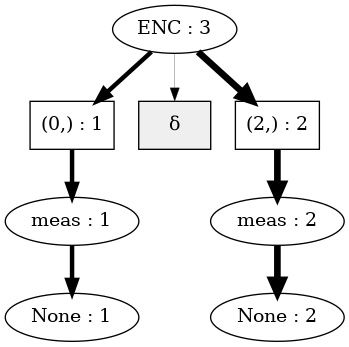

In [ ]:
#| slow

from qsample.examples import ghz1, ghz3, ghz_stab, ftsteane, flagstab, steane0, tele
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.noise import E1
import qsample.callbacks as cb

sample_range = np.logspace(-5,0,11)
err_params = {'q': sample_range}
p_max = {'q': 1e-3}

ss_sam = SubsetSamplerERV(protocol=steane0, simulator=CHP,  p_max=p_max, err_model=E1, err_params=err_params)
ss_sam.run(3, callbacks=[])#cb.PrintERVPerShot()])
# ss_sam.run(100, callbacks=[cb.PlotStats()])

ss_sam.tree.draw(verbose=True)